In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [2]:
yelp_df = pd.read_csv('../input/yelp.csv')
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Exploratory Data Analysis

### Basic Operations for Data
Keep meaningful columns and rename variables

In [3]:
yelp_df = yelp_df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'], axis=1)
yelp_df = yelp_df.rename(columns={'stars':'Stars', 'text':'Text', 'cool':'Cool'
                                  , 'useful':'Useful', 'funny':'Funny'})
yelp_df.head()

,Stars,Text,Cool,Useful,Funny
0,5,My wife took me here on my birthday for breakf...,2,5,0
1,5,I have no idea why some people give bad review...,0,0,0
2,4,love the gyro plate. Rice is so good and I als...,0,1,0
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0


In [4]:
yelp_df['Text Length'] = yelp_df['Text'].apply(len)
yelp_df.head()

,Stars,Text,Cool,Useful,Funny,Text Length
0,5,My wife took me here on my birthday for breakf...,2,5,0,889
1,5,I have no idea why some people give bad review...,0,0,0,1345
2,4,love the gyro plate. Rice is so good and I als...,0,1,0,76
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,419
4,5,General Manager Scott Petello is a good egg!!!...,0,0,0,469


In [5]:
yelp_df.describe()

,Stars,Cool,Useful,Funny,Text Length
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300,710.738700
std,1.214636,2.067861,2.336647,1.907942,617.399827
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,294.000000
50%,4.000000,0.000000,1.000000,0.000000,541.500000
75%,5.000000,1.000000,2.000000,1.000000,930.000000
max,5.000000,77.000000,76.000000,57.000000,4997.000000


A complete data set, without null values. A very good beginning for data analysis

### Data Vasulization - Feature Engineering
In this part, we will conduct descriptive analysis for all variables and then explore the relationship between 'Stars' and other variables.

#### Descriptive Analysis

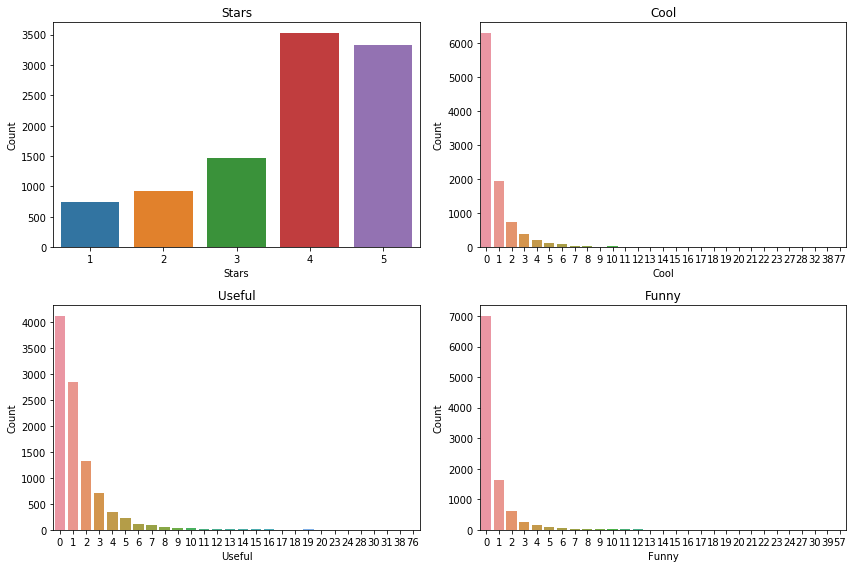

In [6]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='Stars', data=yelp_df)
axes1.set_title('Stars')
axes1.set_ylabel('Count')

axes2 = plt.subplot(2,2,2)
axes2 = sns.countplot(x='Cool', data=yelp_df)
axes2.set_title('Cool')
axes2.set_ylabel('Count')

axes3 = plt.subplot(2,2,3)
axes3 = sns.countplot(x='Useful', data=yelp_df)
axes3.set_title('Useful')
axes3.set_ylabel('Count')

axes4 = plt.subplot(2,2,4)
axes4 = sns.countplot(x='Funny', data=yelp_df)
axes4.set_title('Funny')
axes4.set_ylabel('Count')

plt.tight_layout()

Text(0.5,1,'Text Length Distribution')

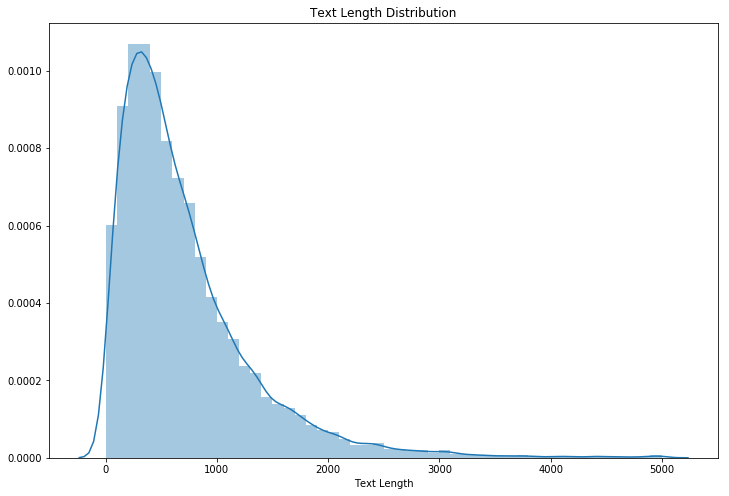

In [7]:
# Text Length
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(12,8))
sns.distplot(yelp_df['Text Length'], kde=True, bins=50)
plt.title('Text Length Distribution')

#### Correlation between Label and Other Variables

Text(0.5,1,'Heatmap of Variables')

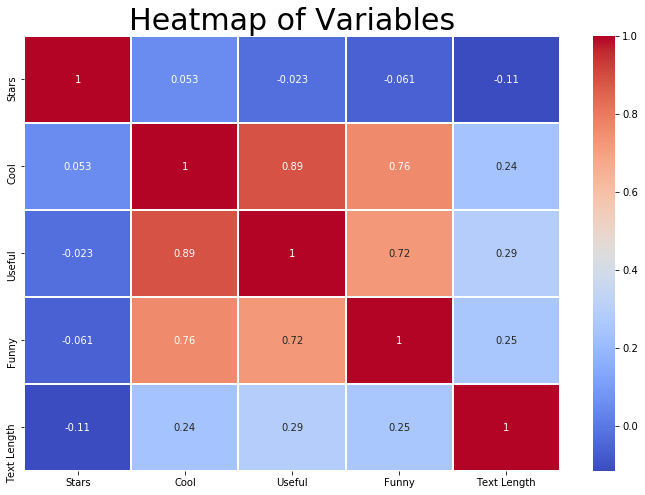

In [8]:
yelp_cor = yelp_df[['Stars', 'Cool', 'Useful', 'Funny', 'Text Length']].corr()

fig = plt.figure(figsize=(12,8))
axes = sns.heatmap(yelp_cor, cmap='coolwarm', linewidth=1, linecolor='white', annot=True)
axes.set_title('Heatmap of Variables', fontsize=30)

The heatmap shows that there is no correlation between stars and other other variables(the coefficients approximate zero). Let use pairplot to check whether other variables can be used to distinguish 'Stars'

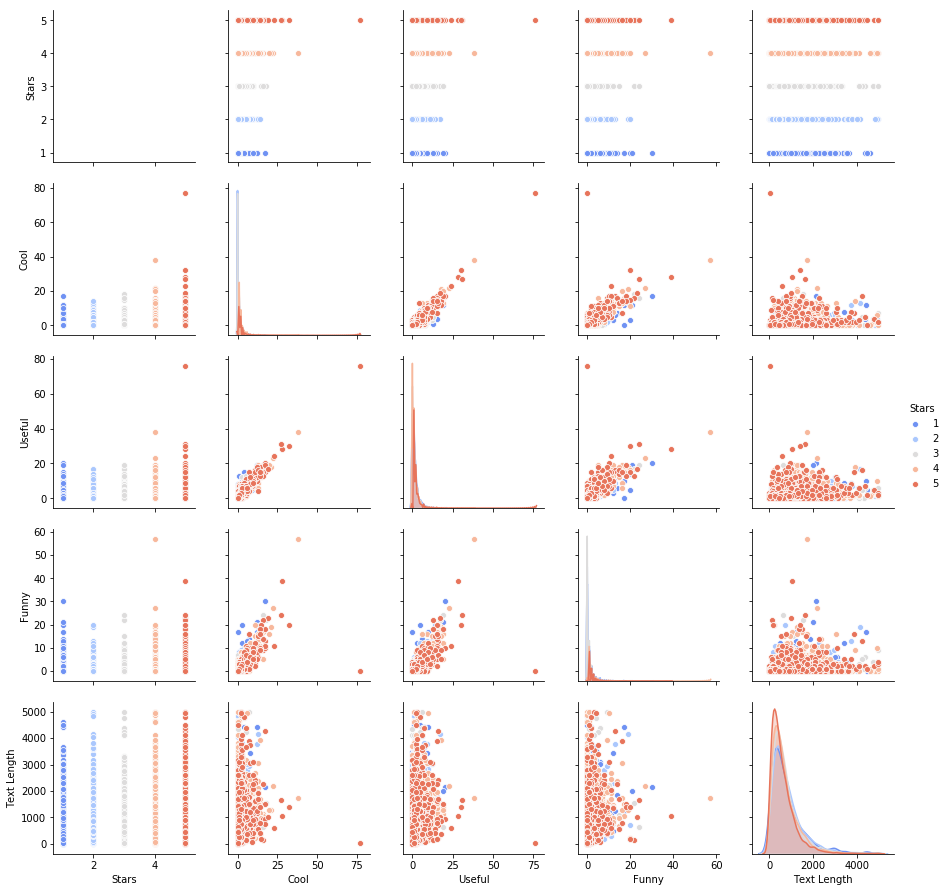

In [9]:
sns.pairplot(yelp_df, hue='Stars', palette='coolwarm')

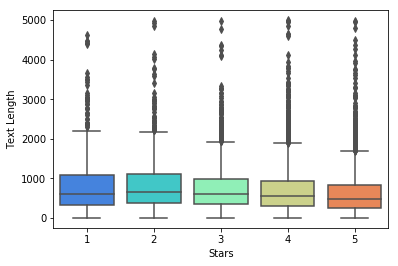

In [10]:
warnings.filterwarnings("ignore")
sns.boxplot(x='Stars', y='Text Length', data=yelp_df, palette='rainbow')

The heatmap, pairplot and boxplot verify that those other numerical variables cannot be used to predict 'Stars'. Therefore, we have to focus on text analysis.

### Text Analysis
For text analysis, we need to remove all punctuations and stopwords. Then we can get word frequency and make some preparations for further building up model.

In [11]:
yelp_text = yelp_df[['Stars', 'Text']]
yelp_text.head()

,Stars,Text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [12]:
def remove_punc_stopword(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    remove_punc = [word for word in text if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word.lower() for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

#### All Stars Word Frequency and Word Cloud

In [13]:
yelp_text_allstars = yelp_text.copy()
yelp_text_allstars['Text'] = yelp_text_allstars['Text'].apply(remove_punc_stopword)
yelp_text_allstars.count()

Stars    10000
Text     10000
dtype: int64

In [14]:
yelp_text_allstars.head()

,Stars,Text
0,5,"[wife, took, birthday, breakfast, excellent, w..."
1,5,"[idea, people, give, bad, reviews, place, goes..."
2,4,"[love, gyro, plate, rice, good, also, dig, can..."
3,5,"[rosie, dakota, love, chaparral, dog, park, co..."
4,5,"[general, manager, scott, petello, good, egg, ..."


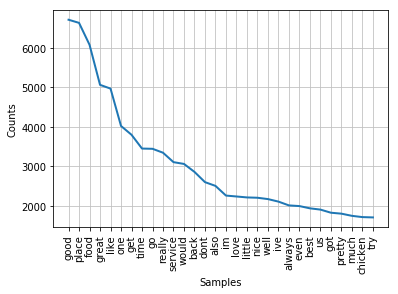

In [15]:
words_split = []
for i in range(0,9999): 
    for word in yelp_text_allstars['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

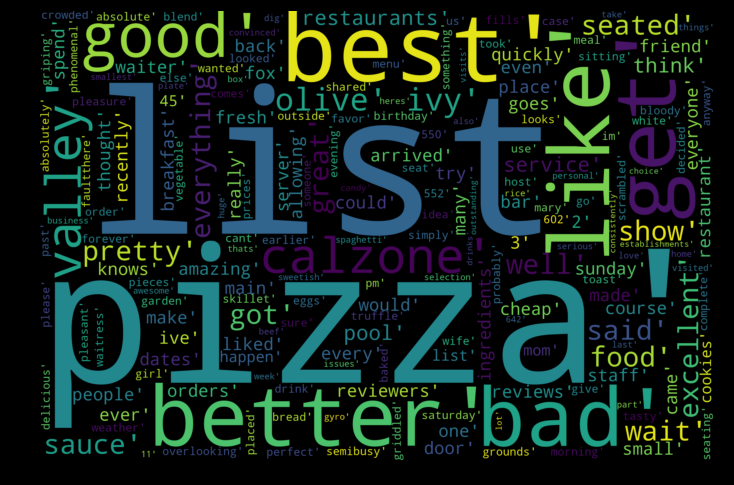

In [16]:
yelp_allstars_text = yelp_text_allstars['Text'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_allstars_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

#### Stars 1 and 5 Words Frequency and Word Cloud

In [17]:
warnings.filterwarnings("ignore")
yelp_text_stars1 = yelp_text[yelp_text['Stars']==1]
yelp_text_stars1['Text'] = yelp_text_stars1['Text'].apply(remove_punc_stopword)
yelp_text_stars1.count()

Stars    749
Text     749
dtype: int64

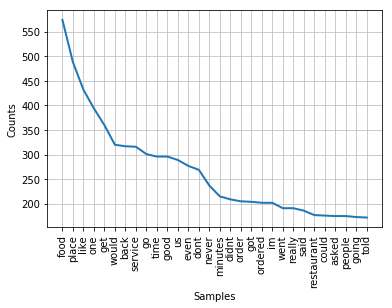

In [18]:
yelp_text_stars1 = yelp_text_stars1.reset_index(drop=True)
words_split = []
for i in range(0,749): 
    for word in yelp_text_stars1['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

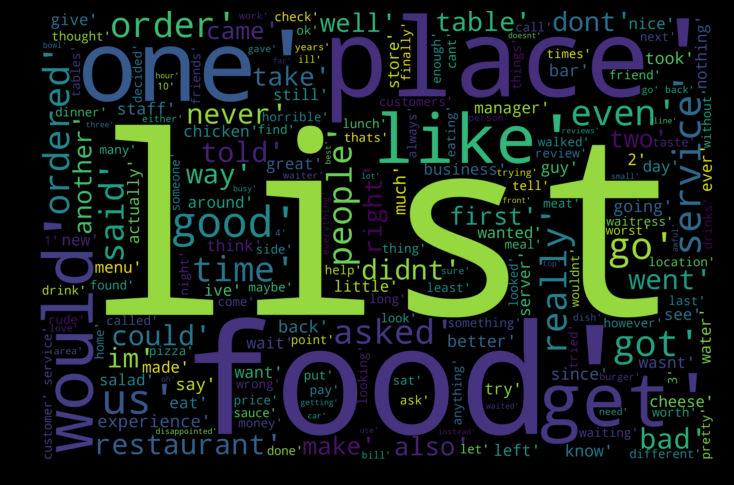

In [19]:
yelp_stars1_text = yelp_text_stars1['Text'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_stars1_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [20]:
warnings.filterwarnings("ignore")
yelp_text_stars5 = yelp_text[yelp_text['Stars']==5]
yelp_text_stars5['Text'] = yelp_text_stars5['Text'].apply(remove_punc_stopword)
yelp_text_stars5.count()

Stars    3337
Text     3337
dtype: int64

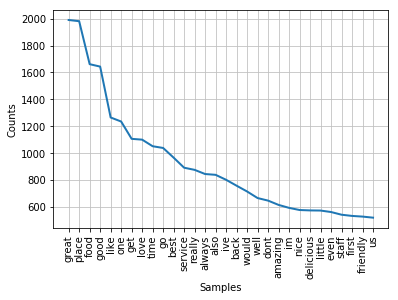

In [21]:
yelp_text_stars5 = yelp_text_stars5.reset_index(drop=True)
words_split = []
for i in range(0,3337): 
    for word in yelp_text_stars5['Text'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

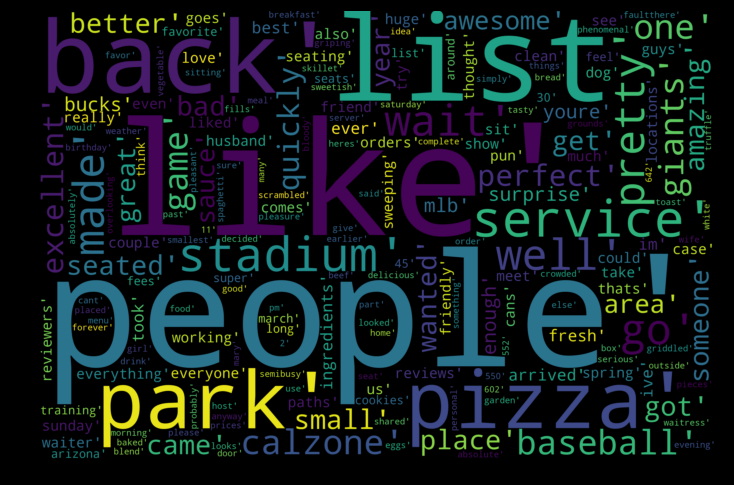

In [22]:
yelp_stars5_text = yelp_text_stars5['Text'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(yelp_stars5_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

## Build up ML Model

### ML for All Stars

#### ML without TF-IDF
Currently, what we have is 'text', which cannot be recoganized by machine learning model. We need to transfer those texts to vectors that can be used in machine learning model. What's more, let's first build up a machine learning model without using TF-IDF (term frequency-inverse document frequency. The tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.

In [23]:
X = yelp_df['Text']
y = yelp_df['Stars']
cv = CountVectorizer()
X = cv.fit_transform(X)

test_size = np.linspace(0.1, 1, num=9, endpoint=False)
random_state = np.arange(0, 43)
grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)     
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
21,0.1,21,0.986


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_test_pred = mnb.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.76      0.51      0.61        69
           2       0.56      0.10      0.17        92
           3       0.25      0.13      0.17       137
           4       0.46      0.68      0.55       373
           5       0.60      0.56      0.58       329

   micro avg       0.50      0.50      0.50      1000
   macro avg       0.53      0.40      0.42      1000
weighted avg       0.51      0.50      0.48      1000



#### ML using TF-IDF
Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document, measuring how frequently a term occures in document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears, measuring how important a term is.


In [25]:
tfidf_transformer = TfidfTransformer().fit(X)
X = tfidf_transformer.transform(X)

grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)     
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
31,0.1,31,1.405


In [26]:
warnings.filterwarnings("ignore")
pipeline = Pipeline([('bow', CountVectorizer()), 
                     ('tfidf', TfidfTransformer()), 
                     ('classifier', MultinomialNB())])

X = yelp_df['Text']
y = yelp_df['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=31)
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        99
           3       0.00      0.00      0.00       144
           4       0.40      0.94      0.56       358
           5       0.78      0.35      0.48       338

   micro avg       0.46      0.46      0.46      1000
   macro avg       0.24      0.26      0.21      1000
weighted avg       0.41      0.46      0.36      1000



Based on these two result, the more accurate results come from Stars5 and Stars1 - the highest star and lowest star. Let's check it by only predict Stars5 and Stars1. And we can not ignore the fact that TF-IDF actually does not improve the accuracy in this case. It may work for other cases. However, for Yelp Reviews, we have to remove it.

### ML for Stars 1 and 5

In [27]:
yelp_df12 = yelp_df[(yelp_df.Stars==1) | (yelp_df.Stars==5)]
X = yelp_df12['Text']
y = yelp_df12['Stars']
cv = CountVectorizer()
X = cv.fit_transform(X)

test_size = np.linspace(0.1, 1, num=9, endpoint=False)
random_state = np.arange(0, 43)
grid_results= []
for testsize in test_size:
    for randomstate in random_state:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate)
            mnb = MultinomialNB()
            mnb.fit(X_train, y_train)
            y_test_pred = mnb.predict(X_test)     
            grid_results.append([testsize, randomstate, mean_squared_error(y_test, y_test_pred)])
            grid_frame = pd.DataFrame(grid_results)
            grid_frame.rename(columns={0:'Test Size', 1:'Random State', 2:'MSE of Test'}, inplace=True)
        except Exception:
            print(Exception.with_traceback())
            print('error')
            continue

min_test_mse = grid_frame[grid_frame['MSE of Test'] == grid_frame['MSE of Test'].min()]
min_test_mse

,Test Size,Random State,MSE of Test
24,0.1,24,0.899756
36,0.1,36,0.899756


In [28]:
pipeline = Pipeline([('bow', CountVectorizer()), 
                     ('classifier', MultinomialNB())])

X = yelp_df12['Text']
y = yelp_df12['Stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=36)
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           1       0.88      0.69      0.77        67
           5       0.94      0.98      0.96       342

   micro avg       0.93      0.93      0.93       409
   macro avg       0.91      0.83      0.87       409
weighted avg       0.93      0.93      0.93       409



These precision results show that we can predict highest and lowest levels with very high accuracy, indicating that we can just focus on these two levels and summarize what yelp should keep when it gets highest star and what it should imporve when it gets lowest star. And these summarizations will come from words frequency analysis which has been conducted above.

## Conclusions
1. For restaurants of Yelp, food and service mean everything. We can find that no matter what star one kinds of restaurants get, more frequent words are food, service and some other words (delicious, friendly, etc.) that are used to describe the quality of them. Therefore, for all restaurants, please leave other factors along and just focus on improving your food and service. This will definitely help you a lot
2. For Yelp reviews, the machine learning model can predict highest and lowest levels using customers' reviews with best accuracy. And during the process of building up model, we must remove some other numerical variables and just keep texts as independent variable.